# Regression spotting project

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import sklearn.model_selection
from matplotlib import pyplot as plt
plt.style.use('dark_background')

from sklearn.preprocessing import StandardScaler
import umap.plot


In [41]:
# Paths:
input_dir = Path.cwd() / "../input_data"
plots_dir = Path.cwd() / "../plots"
plots_dir.mkdir(exist_ok=True)
results_dir = Path.cwd() / "../results"
results_dir.mkdir(exist_ok=True)

## Loading data
Loading fingerprints, and molecule properties


In [3]:
# Load fingerprints:
fingerprints = pd.read_csv(input_dir / "fingerprints.csv", index_col=0)
fingerprints.sort_index(inplace=True)
# There seems to be some duplicates in the rows:
fingerprints.drop_duplicates(inplace=True)
# Save columns names:
fingerprints_cols = fingerprints.columns

fingerprints
# fingerprints.addu

,1,8,13,26,27,31,35,41,45,62,...,1977,1991,1992,1995,2001,2004,2018,2034,2038,2044
mol_name,,,,,,,,,,,,,,,,,,,,,
2-Oxoglutaric acid,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3-Hydroxyanthranilic acid,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3-Hydroxymethylglutaric acid,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3-Phosphoglyceric acid,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"4,5-Dihydroorotic acid",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xanthine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
alpha-tocopherol,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cis-Aconitic acid,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Load properties:
mol_properties = pd.read_csv(input_dir / "physchem_properties.csv", index_col=0)
mol_properties.sort_index(inplace=True)
mol_properties.drop_duplicates(inplace=True)
# mol_properties.set_index("name_short", inplace=True)
mol_properties_cols = mol_properties.columns
mol_properties

,pka_strongest_acidic,pka_strongest_basic,polar_surface_area,polarizability,acceptor_count,donor_count,physiological_charge
name_short,,,,,,,
2-Oxoglutaric acid,2.66,-9.70,91.67,12.17,5.0,2.0,-2.0
3-Hydroxyanthranilic acid,1.94,4.82,83.55,14.18,4.0,3.0,-1.0
3-Hydroxymethylglutaric acid,3.68,-3.00,94.83,14.55,5.0,3.0,-2.0
3-Phosphoglyceric acid,1.30,-4.20,124.29,13.29,6.0,4.0,-3.0
"4,5-Dihydroorotic acid",3.28,-8.20,95.50,13.09,4.0,3.0,-1.0
...,...,...,...,...,...,...,...
Xanthine,7.95,-0.70,86.88,12.70,3.0,3.0,0.0
alpha-tocopherol,10.80,-4.90,29.46,55.29,2.0,1.0,0.0
cis-Aconitic acid,2.11,NaN,111.90,14.16,6.0,3.0,-3.0


Check statistics of molecular properties and handle NaN values:


/tmp/ipykernel_3887124/534195647.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  mol_properties.hist(ax=ax)


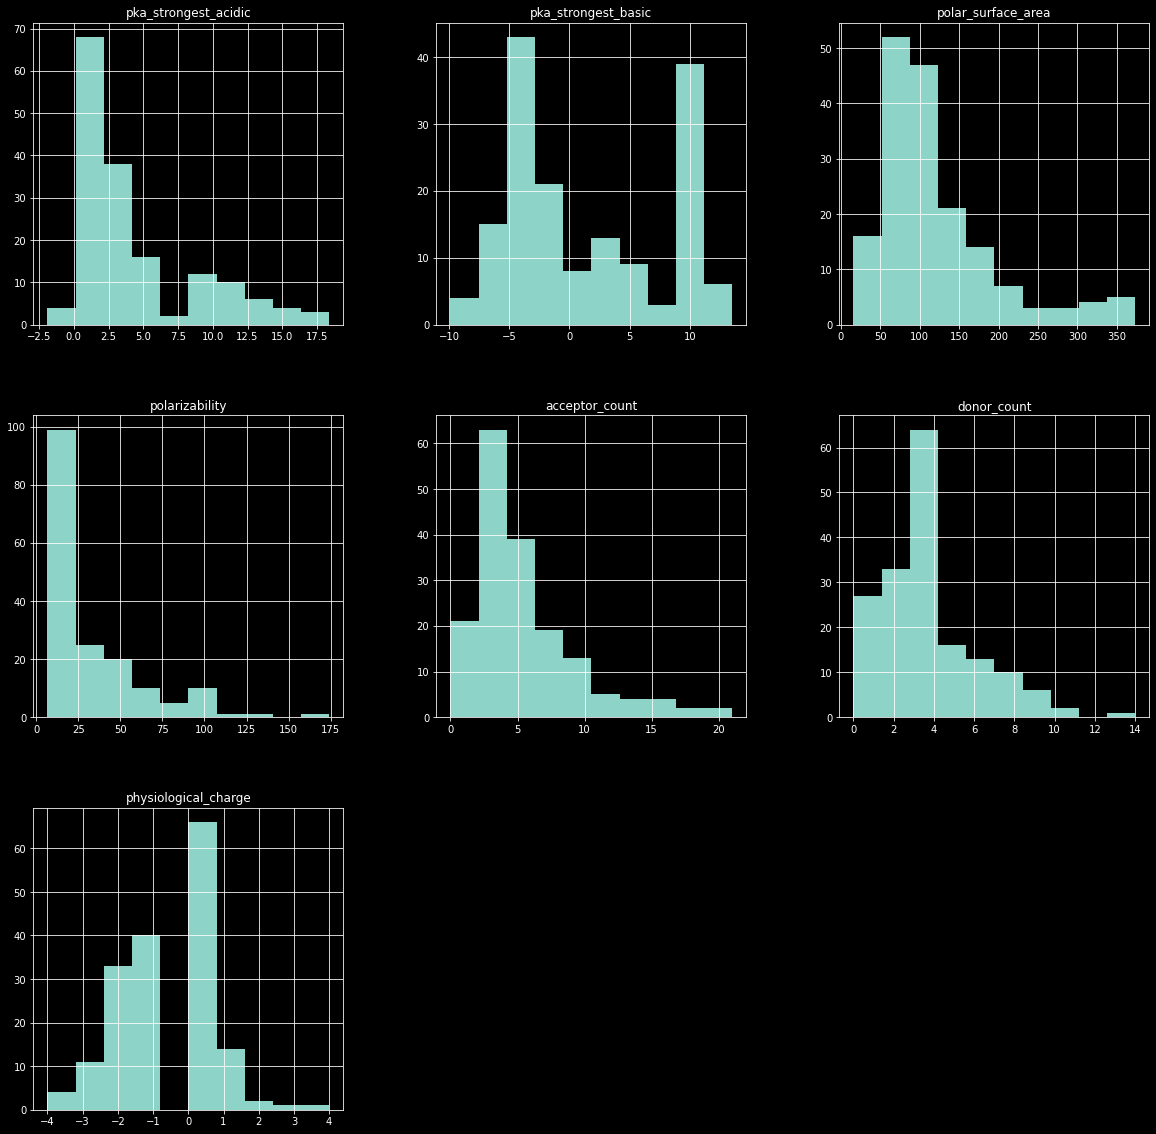

In [5]:
# Plot histograms:
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
mol_properties.hist(ax=ax)
fig.savefig(plots_dir / "mol_features.pdf")

In [6]:
# Check for NaN values:
is_null = mol_properties.isnull()
for col in mol_properties_cols:
    print("---")
    print(is_null[col].value_counts())

# FIXME: temporarely set NaN to zero
mol_properties[is_null] = 0.

---
False    163
True       9
Name: pka_strongest_acidic, dtype: int64
---
False    161
True      11
Name: pka_strongest_basic, dtype: int64
---
False    172
Name: polar_surface_area, dtype: int64
---
False    172
Name: polarizability, dtype: int64
---
False    172
Name: acceptor_count, dtype: int64
---
False    172
Name: donor_count, dtype: int64
---
False    172
Name: physiological_charge, dtype: int64


In [7]:
# Perform some basic checks:
assert fingerprints.index.is_unique
assert mol_properties.index.is_unique

In [8]:
print("Number of fingerprints: ", len(fingerprints))
print("Number of mol properties: ", len(mol_properties))

print("Molecules with missing fingerprints: ")
missing_molecules = list(mol_properties[~ mol_properties.index.isin(fingerprints.index)].index)
print(missing_molecules)

# min(fingerprints.iloc[3, ] == fingerprints.iloc[4, ])


Number of fingerprints:  169
Number of mol properties:  172
Molecules with missing fingerprints: 
['Adenosine triphosphate', 'Ribose 5-phosphate', 'Spermine']


Merge fingerprints and properties:

In [9]:
all_mol_features = pd.merge(mol_properties, fingerprints, how="inner", right_index=True, left_index=True)
all_mol_features


,pka_strongest_acidic,pka_strongest_basic,polar_surface_area,polarizability,acceptor_count,donor_count,physiological_charge,1,8,13,...,1977,1991,1992,1995,2001,2004,2018,2034,2038,2044
2-Oxoglutaric acid,2.66,-9.70,91.67,12.17,5.0,2.0,-2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3-Hydroxyanthranilic acid,1.94,4.82,83.55,14.18,4.0,3.0,-1.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3-Hydroxymethylglutaric acid,3.68,-3.00,94.83,14.55,5.0,3.0,-2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3-Phosphoglyceric acid,1.30,-4.20,124.29,13.29,6.0,4.0,-3.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
"4,5-Dihydroorotic acid",3.28,-8.20,95.50,13.09,4.0,3.0,-1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xanthine,7.95,-0.70,86.88,12.70,3.0,3.0,0.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
alpha-tocopherol,10.80,-4.90,29.46,55.29,2.0,1.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
cis-Aconitic acid,2.11,0.00,111.90,14.16,6.0,3.0,-3.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
gamma-Aminobutyric acid,4.53,10.22,63.32,10.62,3.0,2.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Loading intensities

In [10]:
# Intensities:
intensities = pd.read_csv(input_dir / "3june22_ions_no_nl.csv", index_col=0)
intensities.head()

,Matrix short,Polarity,adduct,name_short,detected,spot_intensity
0,9AA,negative,+Cl,2-Oxoglutaric acid,0,0.00000
1,9AA,negative,+Cl,3-Hydroxyanthranilic acid,1,41.60611
2,9AA,negative,+Cl,3-Hydroxymethylglutaric acid,0,0.00000
3,9AA,negative,+Cl,3-Phosphoglyceric acid,0,0.00000
4,9AA,negative,+Cl,"4,5-Dihydroorotic acid",1,160.79555


In [11]:
# Sanity checks:
nb_before = len(intensities.name_short.unique())

# Delete molecules with missing properties:
intensities = intensities[~intensities.name_short.isin(missing_molecules)]
print("{}/{} molecules kept".format(len(intensities.name_short.unique()), nb_before))



169/172 molecules kept


#### Remove molecule-adduct combinations that were never observed in any matrix

In [12]:
remove_not_detected_adducts = False

if remove_not_detected_adducts:
    g = intensities.groupby(["name_short", "adduct"], as_index=False)["detected"].max()
    nb_comb_before = intensities.shape[0]
    intensities = intensities.merge(g[g["detected"] == 1][["name_short", "adduct"]])
    print("{}/{} combinations of molecules/adduct with non-zero observed values".format(intensities.shape[0], nb_comb_before))

    # Now check if some molecules are never observed (for any adduct) and
    # remove them from the feature vectors:
    nb_mol_before = len(all_mol_features.index)
    all_mol_features = all_mol_features[all_mol_features.index.isin(intensities["name_short"].unique())]
    print("{}/{} molecules with non-zero observed values".format(len(all_mol_features.index), nb_mol_before))

#### How many molecules-adduct observed per matrix-polarity


In [13]:
g = intensities.groupby(['Matrix short', 'Polarity'], as_index=False)
detected_ratio = g["detected"].apply(lambda x: x.sum() / x.shape[0])
detected_ratio["Sum detected"] = g["detected"].sum()["detected"]

# Show values:
detected_ratio.sort_values("detected", ascending=False).rename(columns={"detected": "Ratio detected molecules"})

,Matrix short,Polarity,Ratio detected molecules,Sum detected
13,DHB,positive,0.322908,382
7,ClCCA,positive,0.308538,365
3,CHCA,positive,0.300085,355
11,DHAP,positive,0.232460,275
19,pNA,positive,0.231615,274
5,CMBT,positive,0.229924,272
9,DAN,positive,0.176669,209
0,9AA,negative,0.141167,167
17,NOR,positive,0.135249,160
8,DAN,negative,0.131023,155


Get statistics about adducts:


/tmp/ipykernel_3887124/3698744177.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  std_intesities.hist(column=["detected"], by=['Matrix short', "Polarity"], grid=False, ax=ax)


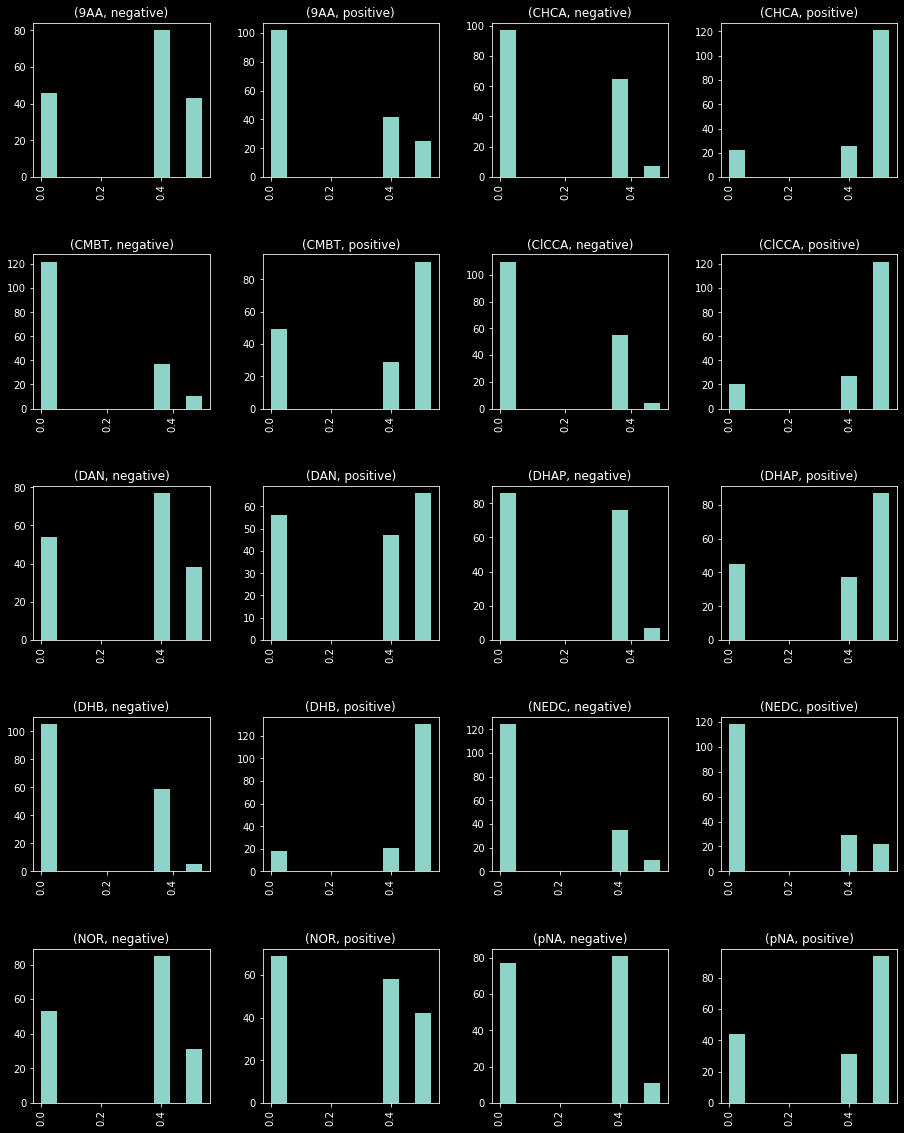

In [14]:
std_intesities = intensities.groupby(['Matrix short', "Polarity", "name_short"], as_index=False).std()

fig = plt.figure(figsize = (15,20))
ax = fig.gca()
std_intesities.hist(column=["detected"], by=['Matrix short', "Polarity"], grid=False, ax=ax)
fig.savefig(plots_dir / "std_detected_value.pdf")



In [15]:
# Check if entries with std=0 are always not detected:
std_intesities[std_intesities["detected"] == 0]["spot_intensity"].value_counts()

0.0    1417
Name: spot_intensity, dtype: int64

**Conclusion**: Intensities always vary across adducts (in histograms, std=0 entries were never detected for any adducts)

In [16]:
# Convert adducts to one-hot encoding:
adducts_one_hot = pd.get_dummies(intensities.adduct, prefix='adduct')
adducts_columns = adducts_one_hot.columns
intensities = intensities.merge(right=adducts_one_hot, right_index=True, left_index=True)

### How many matrices with non-zero values per molecule+adduct
Many adducts occure in several matrices, but let's see how intensities look like, ranked by higher to lower:

In [17]:
g = intensities.sort_values("spot_intensity", ascending=False).groupby(["name_short", "adduct"], as_index=False)
intensity_stats = g["detected"].sum()
for matrix_index in range(20):
    # intensity_stats["matrix_{}".format(matrix_index)] = g["spot_intensity"].max()["spot_intensity"]
    intensity_stats["matrix_{}".format(matrix_index)] = g["spot_intensity"].apply(lambda x: x.iloc[matrix_index])["spot_intensity"]
# assert intensity_stats["max"].equals(intensity_stats["max2"])
intensity_stats


,name_short,adduct,detected,matrix_0,matrix_1,matrix_2,matrix_3,matrix_4,matrix_5,matrix_6,...,matrix_10,matrix_11,matrix_12,matrix_13,matrix_14,matrix_15,matrix_16,matrix_17,matrix_18,matrix_19
0,2-Oxoglutaric acid,+Cl,0,0.000000,0.00000,0.000000,0.00000,0.000000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2-Oxoglutaric acid,+H,0,0.000000,0.00000,0.000000,0.00000,0.000000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2-Oxoglutaric acid,+K,1,11.875473,0.00000,0.000000,0.00000,0.000000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2-Oxoglutaric acid,+Na,5,210.545460,79.31094,76.893745,72.43064,54.591070,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2-Oxoglutaric acid,-H,9,65207.863000,36786.18400,6752.459000,6166.86670,1492.598300,1489.3842,930.48126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,myo-Inositol,+K,1,509.492550,0.00000,0.000000,0.00000,0.000000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1179,myo-Inositol,+Na,8,4049.503000,1613.17870,1452.607400,1354.67750,772.020600,648.3625,535.32074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1180,myo-Inositol,-H,5,1942.043300,455.85037,318.541720,130.82251,11.486426,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1181,myo-Inositol,[M]+,0,0.000000,0.00000,0.000000,0.00000,0.000000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Intensity histograms across matrices (before normalization)
Only plot intensities > 100:

/tmp/ipykernel_3887124/771068752.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  _ = intensities[intensities["spot_intensity"] > 100.].hist("spot_intensity", by=["Matrix short", "Polarity"], ax=ax, sharex=True)


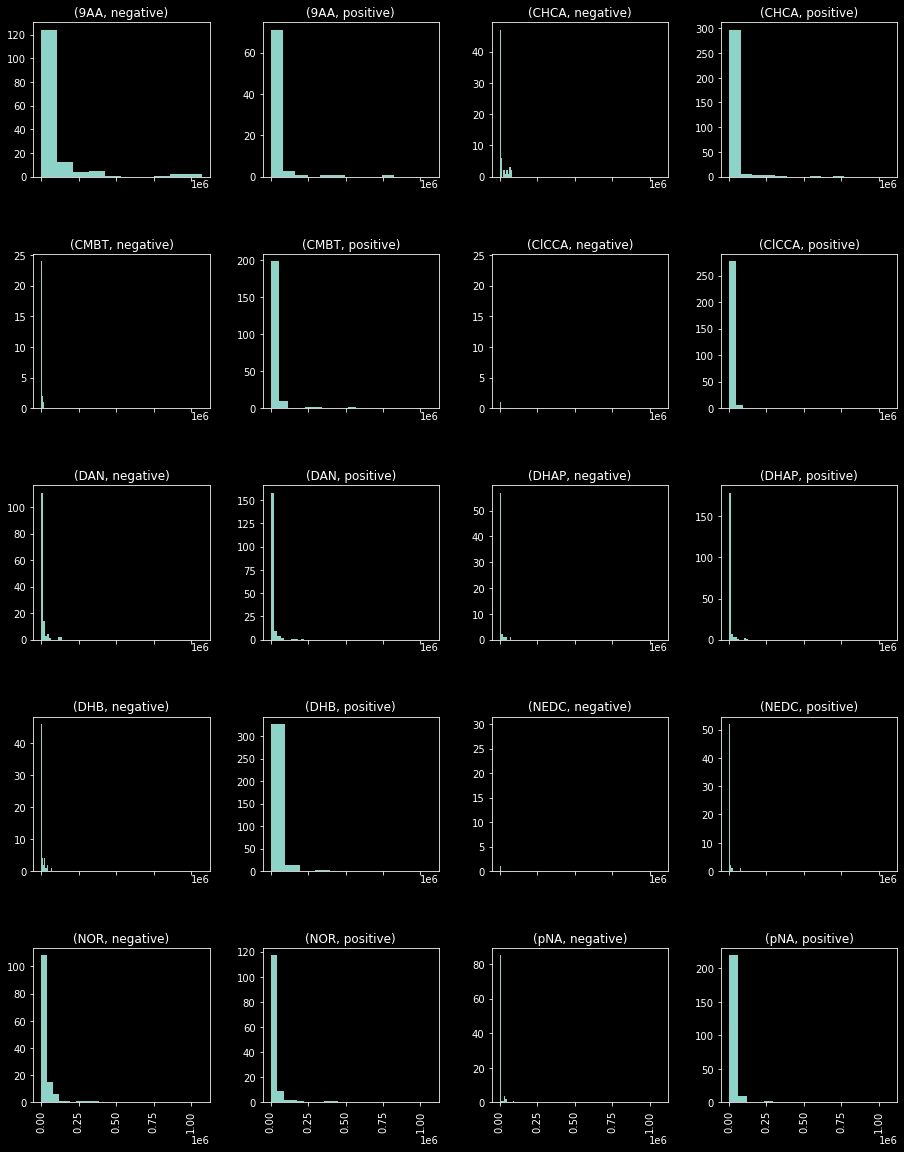

In [18]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()


_ = intensities[intensities["spot_intensity"] > 100.].hist("spot_intensity", by=["Matrix short", "Polarity"], ax=ax, sharex=True)

## Methods for standartization/normalization
First, normalize features

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer


ss = StandardScaler()
pt = PowerTransformer()

#OPTION 1
features_norm_df = pd.DataFrame(pt.fit_transform(all_mol_features),
                                index = all_mol_features.index,
                                columns = all_mol_features.columns)

# OPTION 2
#features_norm_df = pd.DataFrame(ss.fit_transform(all_mol_features), index = all_mol_features.index, columns = all_mol_features.columns)

# OPTION 3 (Seurat normalization)
#features_norm_df = np.log2((all_mol_features.T / all_mol_features.T.sum().values) * 10000 + 1).T


#### Intensities normalization

In [20]:
intensities[intensities["spot_intensity"] < 100]["spot_intensity"] = 0

# V1 normalization:
intensities["norm_intensity"] = pt.fit_transform(intensities[["spot_intensity"]])

# V2:
numpy_intensities = intensities[["spot_intensity"]].to_numpy()
intensities["norm_intensity_seurat"] = np.log2((numpy_intensities.T / numpy_intensities.T.sum()) * 10000 + 1).T

/tmp/ipykernel_3887124/368702662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intensities[intensities["spot_intensity"] < 100]["spot_intensity"] = 0


Histograms for normalization_v1: zeros values are mapped to negative values. Everything that originally had intensity < 100 is not plotted

/tmp/ipykernel_3887124/3901020846.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  _ = intensities[intensities["spot_intensity"] > 100].hist("norm_intensity", by=["Matrix short", "Polarity"], ax=ax, sharex=True)


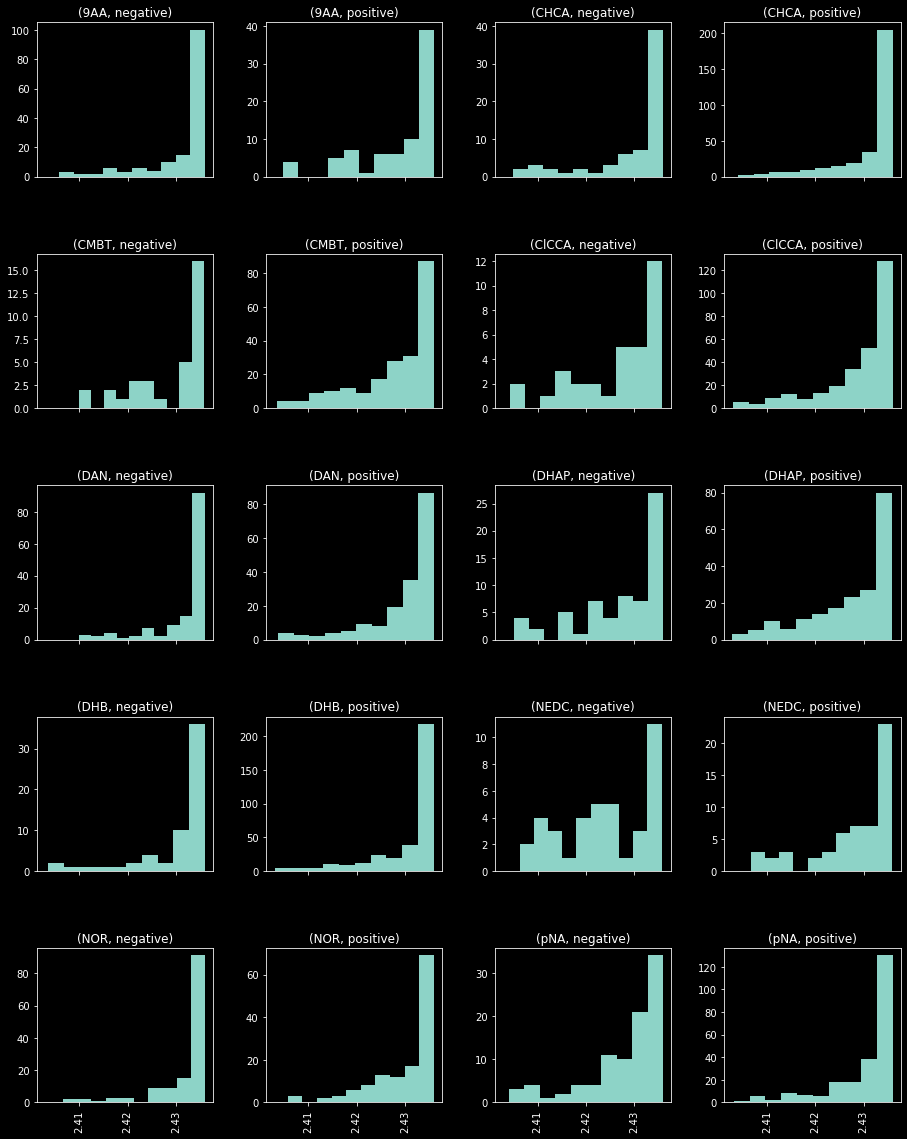

In [21]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()


_ = intensities[intensities["spot_intensity"] > 100].hist("norm_intensity", by=["Matrix short", "Polarity"], ax=ax, sharex=True)

Histograms for Seurat normalization:

/tmp/ipykernel_3887124/3336825856.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  _ = intensities[intensities["spot_intensity"] > 100].hist("norm_intensity_seurat", by=["Matrix short", "Polarity"], ax=ax, sharex=True)


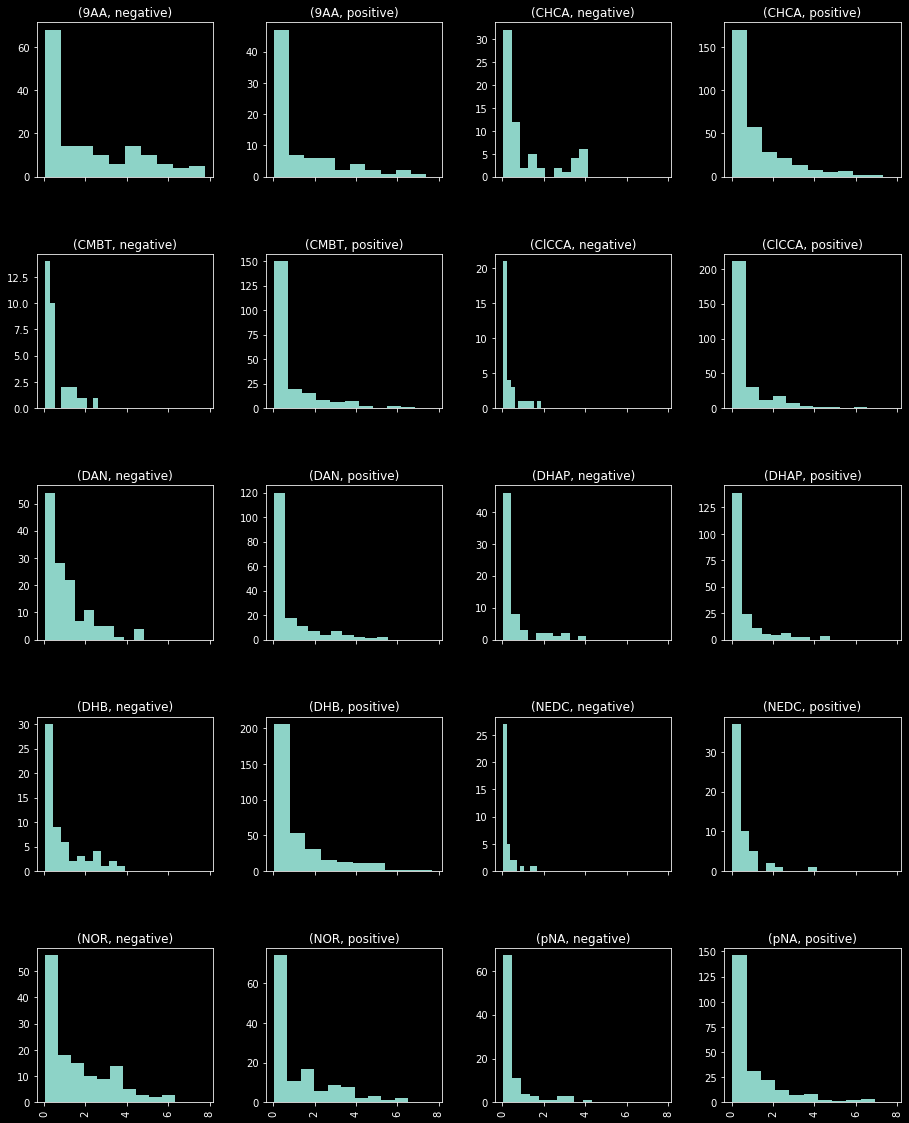

In [22]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()


_ = intensities[intensities["spot_intensity"] > 100].hist("norm_intensity_seurat", by=["Matrix short", "Polarity"], ax=ax, sharex=True)

Overwrite original intensities values with normalization v1:

In [23]:
intensities["spot_intensity"] = intensities["norm_intensity"]



## Data visualization in UMAP space

### UMAP based on molecule features

In [24]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(features_norm_df[mol_properties_cols])

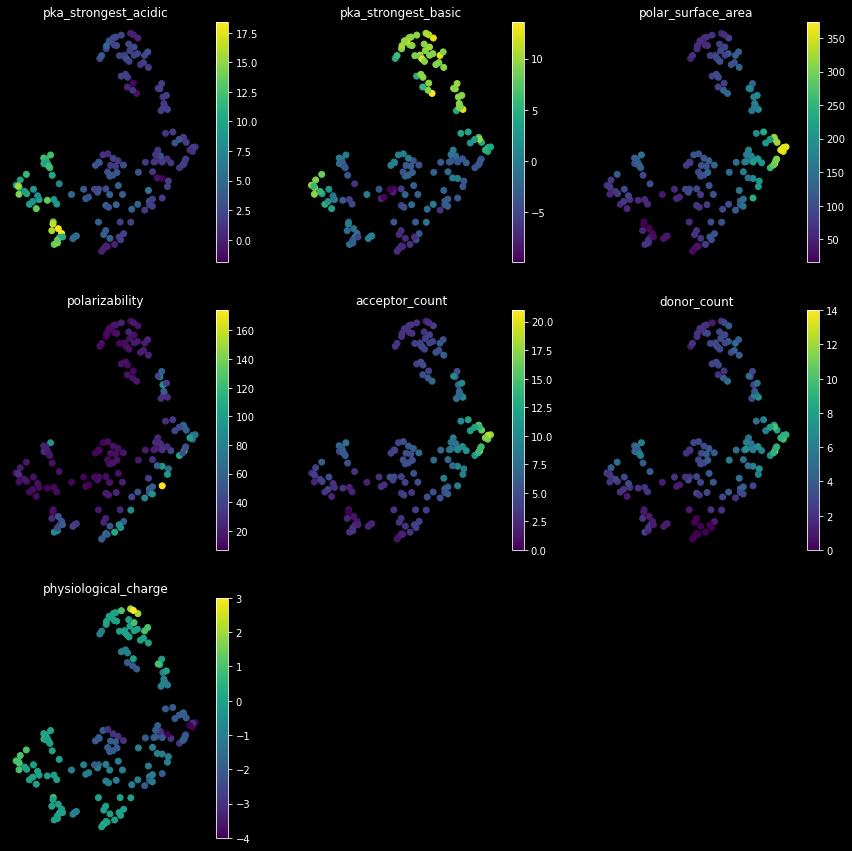

In [25]:
num_rows = 3
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = [axes[i,j] for i in range(num_cols) for j in range(num_rows)]
for i, ax in enumerate(axes):
    if i < len(mol_properties_cols):
        sc = ax.scatter(embedding[:, 0], embedding[:, 1], c = all_mol_features[mol_properties_cols[i]],
               # cmap = plt.cm.SOME_CM
               )
        plt.colorbar(sc, ax=ax)
        ax.set_title(mol_properties_cols[i])
    ax.axis('off')

### UMAP based on fingerprints


In [26]:
embedding = reducer.fit_transform(features_norm_df[fingerprints_cols])

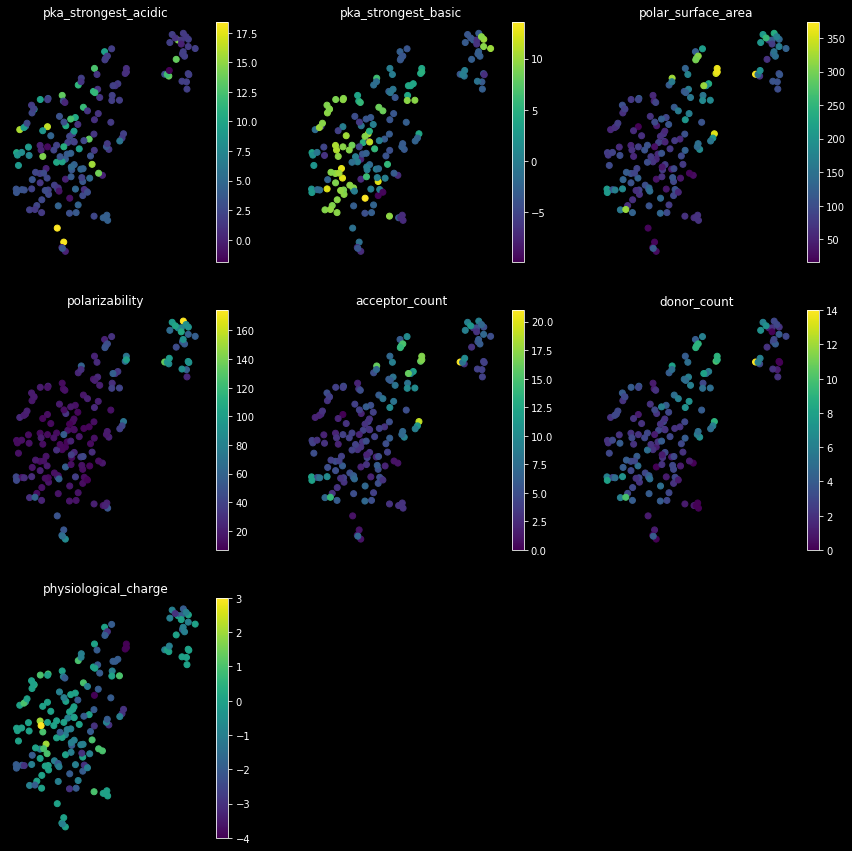

In [27]:
num_rows = 3
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = [axes[i,j] for i in range(num_cols) for j in range(num_rows)]
for i, ax in enumerate(axes):
    if i < len(mol_properties_cols):
        sc = ax.scatter(embedding[:, 0], embedding[:, 1], c = all_mol_features[mol_properties_cols[i]],
               # cmap = plt.cm.SOME_CM
               )
        plt.colorbar(sc, ax=ax)
        ax.set_title(mol_properties_cols[i])
    ax.axis('off')




### UMaps showing intensity per matrix
First, try to compute UMAP on all intensities (add adducts as binary features):

In [28]:
fingerprints_plus_adducts_feat = pd.merge(intensities[adducts_columns.tolist() + ["name_short"]],
                         features_norm_df[fingerprints_cols],
                         how="left",
                         right_index=True,
                         left_on="name_short"
                         ).drop(columns=["name_short"])
embedding = reducer.fit_transform(fingerprints_plus_adducts_feat)


/home/bailoni/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


IndexError: index 23660 is out of bounds for axis 0 with size 23660

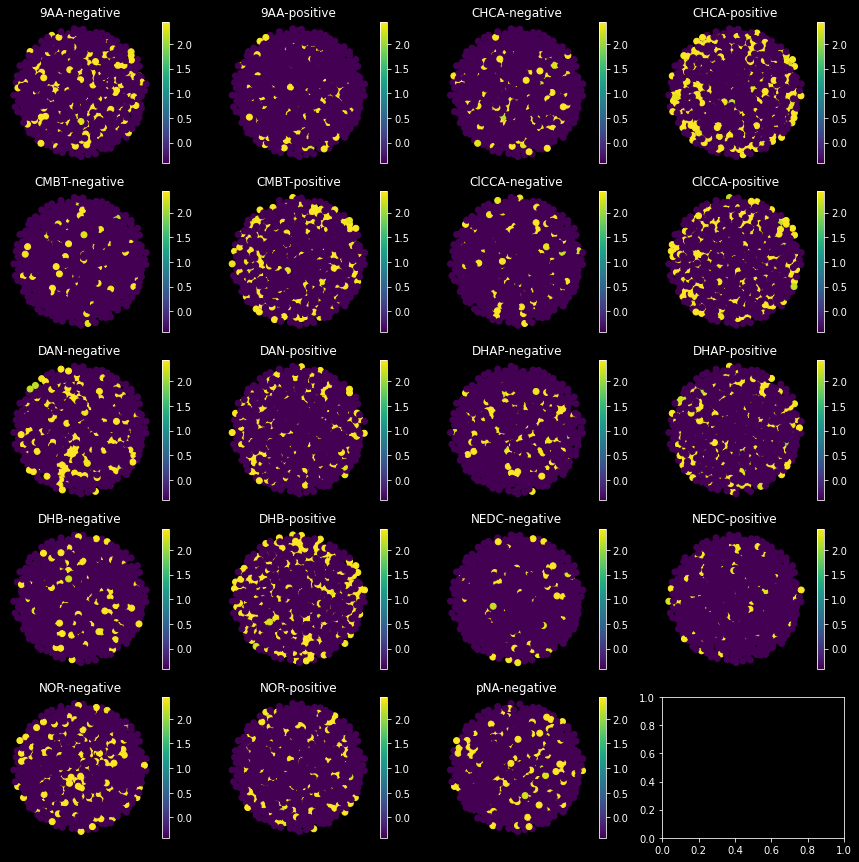

In [29]:
num_rows = 5
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = [axes[i,j] for i in range(num_rows) for j in range(num_cols)]

for i, ((matrix, polarity), rows) in enumerate(intensities.groupby(by=["Matrix short", "Polarity"])):
    ax = axes[i]
    sc = ax.scatter(embedding[rows.index, 0], embedding[rows.index, 1]
                    , c = rows["spot_intensity"],
               )
    plt.colorbar(sc, ax=ax)
    ax.set_title(f"{matrix}-{polarity}")
    ax.axis('off')
    # break
plt.show()


## Create train/val split

First, binarize the molecule features:

/tmp/ipykernel_3887124/3141029475.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  features_norm_df[mol_properties_cols].hist(ax=ax)


array([[<AxesSubplot:title={'center':'pka_strongest_acidic'}>,
        <AxesSubplot:title={'center':'pka_strongest_basic'}>,
        <AxesSubplot:title={'center':'polar_surface_area'}>],
       [<AxesSubplot:title={'center':'polarizability'}>,
        <AxesSubplot:title={'center':'acceptor_count'}>,
        <AxesSubplot:title={'center':'donor_count'}>],
       [<AxesSubplot:title={'center':'physiological_charge'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

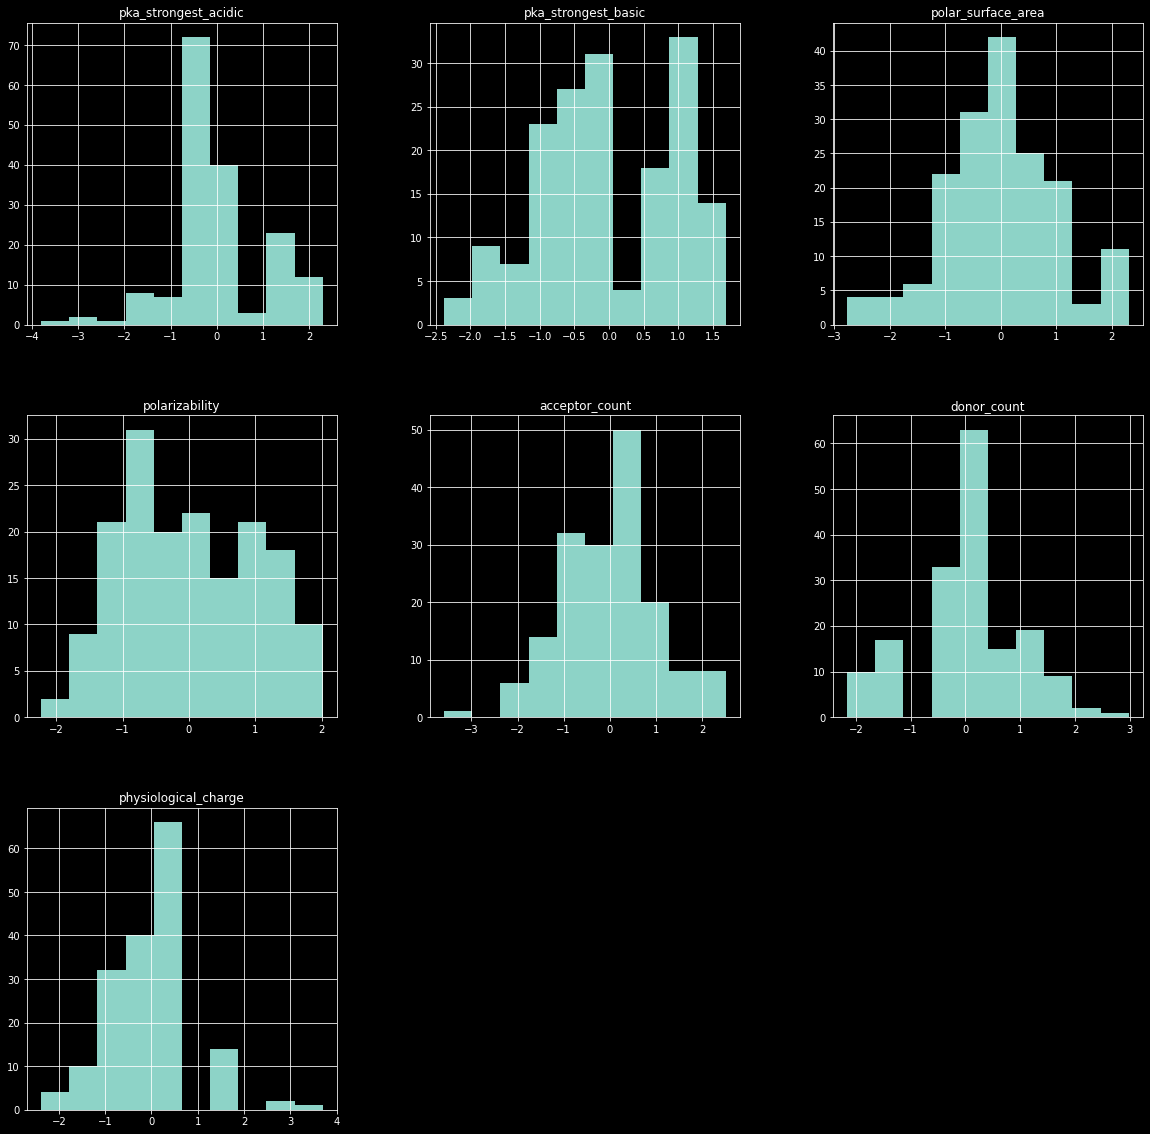

In [30]:
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
features_norm_df[mol_properties_cols].hist(ax=ax)


Since not all the bins have enough datapoints, use quantiles to define the size of the bins:

In [31]:
# We only select only some features, otherwise there are not enough data in each of the splits:
# selected_stratification_features = [
#     "pka_strongest_basic",̊
#     "polar_surface_area",
#     "polarizability"
# ]
selected_stratification_features = mol_properties_cols

digitized_mol_properties = pd.DataFrame(index=features_norm_df.index)
for col in selected_stratification_features:
    digitized_mol_properties[col] = pd.qcut(features_norm_df[col], q=2, labels=[1, 2])

# digitized_mol_properties.value_counts()
# digitized_mol_properties


Now let's get the product of all the classes used for stratification:

In [32]:
intensities.columns


Index(['Matrix short', 'Polarity', 'adduct', 'name_short', 'detected',
       'spot_intensity', 'adduct_+Cl', 'adduct_+H', 'adduct_+K', 'adduct_+Na',
       'adduct_-H', 'adduct_[M]+', 'adduct_[M]-', 'norm_intensity',
       'norm_intensity_seurat'],
      dtype='object')

In [33]:
# First, remove adduct information from the intensity dataframe:
matrix_pol_df = intensities.drop(columns=['adduct', 'detected',
       'spot_intensity']).drop_duplicates().set_index('name_short', )

strat_feat = pd.merge(matrix_pol_df, digitized_mol_properties, how="left", left_index=True,
         right_index=True)
strat_feat.value_counts()

strat_feat['combined'] = strat_feat.astype(str).sum(axis=1).astype('category')

In [34]:
digitized_mol_properties['combined'] = digitized_mol_properties.astype(str).sum(axis=1).astype('category')

# digitized_mol_properties['combined'].value_counts()





## Train regression models


In [35]:
# Define cross-validation objects:
NUM_SPLITS = 5
skf = sklearn.model_selection.StratifiedKFold(n_splits=NUM_SPLITS)
skf.get_n_splits()


5

Define training functions

In [36]:
from tqdm import notebook

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.linear_model import LinearRegression

def train_test_regression_models(train_x, test_x, train_y, test_y, model_set=(),
                                 name_test=None, train=True):
    results_df = pd.DataFrame()
    regressors = {
        'Lin_reg': LinearRegression(),
        'SVR_rbf': SVR(kernel='rbf', C=100, gamma='auto'),
        'SVR_lin': SVR(kernel='linear', C=100, gamma='auto'),
        'SVR_poly': SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1),
        'KNeighbors': KNeighborsRegressor(n_neighbors=5),
        'DecisionTree': DecisionTreeRegressor(max_depth=5),
        'RandomForest': RandomForestRegressor(max_depth=5, n_estimators=10),
        'MLP': MLPRegressor(max_iter=1000),
        'GaussianProcess': GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel())
    }

    if len(model_set)==0: model_set = regressors.keys()

    pbar = notebook.tqdm(model_set, leave=False)
    # for r in model_set:
    for r in pbar:
        pbar.set_postfix({'regressor': r})
        regressor = regressors[r]
        if train:
            regressor.fit(train_x, train_y)
            y_pred = regressor.predict(test_x)

            loc_res_df = pd.DataFrame({'observed_value': test_y,
                                       'prediction': y_pred,
                                       'regressor': r})
        else:
            loc_res_df = pd.DataFrame({'observed_value': test_y,
                                       'prediction': 0.,
                                       'regressor': r})
        if name_test is not None:
            loc_res_df = loc_res_df.merge(name_test, left_index=True, right_index=True)
        results_df = pd.concat([results_df, loc_res_df])
    results_df = results_df.reset_index(drop = True)
    return results_df


In [37]:
def train_with_cross_val(features_normalized):
    # Cross-validation loop:
    regression_results = pd.DataFrame(columns = ['matrix', 'polarity', 'regressor', "observed_value", 'prediction'])
    pbar_cross_split = notebook.tqdm(skf.split(digitized_mol_properties.index, digitized_mol_properties['combined']), leave=False, total=NUM_SPLITS)
    # tqdm()
    for train_index, test_index in pbar_cross_split:
        # pbar_cross_split.set_postfix({'Cross-validation split': r})
        pbar_matrices = notebook.tqdm(intensities.groupby(by=["Matrix short", "Polarity"]), leave=False)
        for (matrix, polarity), rows in pbar_matrices:
            train_intensities = rows[rows.name_short.isin(digitized_mol_properties.index[train_index])]
            test_intensities = rows[rows.name_short.isin(digitized_mol_properties.index[test_index])]

            train_y = train_intensities.spot_intensity.to_numpy()
            test_y = test_intensities.spot_intensity.to_numpy()

            # print(train_intensities[adducts_columns])
            train_x = \
                pd.merge(train_intensities[adducts_columns.tolist() + ["name_short"]],
                         features_normalized,
                         how="left",
                         right_index=True,
                         left_on="name_short"
                         ).drop(columns=["name_short"]).to_numpy()
            test_x = \
                pd.merge(test_intensities[adducts_columns.tolist() + ["name_short", "adduct"]],
                         features_normalized,
                         how="left",
                         right_index=True,
                         left_on="name_short"
                         )

            test_mol_names = test_x[["name_short", "adduct"]].reset_index(drop = True)
            test_x = test_x.drop(columns=["name_short", "adduct"]).to_numpy()

            results_df = train_test_regression_models(train_x, test_x, train_y, test_y,
                                                      name_test=test_mol_names,
                                                      train=True)

            results_df["matrix"] = matrix
            results_df["polarity"] = polarity
            regression_results = pd.concat([regression_results, results_df])
    return regression_results

Now, train regressors using:
- Only fingerprints
- Only mol features
- Both mol features and fingerprints

In [ ]:
# All features:
import time

# tick = time.time()
# print('Took {} s'.format(time.time()-tick))
# regression_results_mols = train_with_cross_val(features_norm_df[mol_properties_cols])
# print('Took {} s'.format(time.time()-tick))
tick = time.time()
regression_results_mols.to_csv(plots_dir / "../results/regr_results_mol_feat.csv")
regression_results_fingerprints = train_with_cross_val(features_norm_df[fingerprints_cols])
print('Took {} s'.format(time.time()-tick))
tick = time.time()
regression_results_fingerprints.to_csv(plots_dir / "../results/regr_results_fingerprints.csv")
regression_results_all_feat = train_with_cross_val(features_norm_df)
print('Took {} s'.format(time.time()-tick))
tick = time.time()
regression_results_all_feat.to_csv(plots_dir / "../results/regr_results_all_feat.csv")

  0%|          | 0/5 [00:00<?, ?it/s]

/home/bailoni/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [181]:
import pandas as pd
import numpy as np
from tqdm import tqdm

df = pd.DataFrame(np.random.randint(0, 100, (1000000, 100)))

tqdm.pandas(desc="power DataFrame 1M to 100 random int!")

df.progress_apply(lambda x: x**2)
df.groupby(0).progress_apply(lambda x: x**2)

power DataFrame 1M to 100 random int!: 100%|██████████| 100/100 [00:02<00:00, 43.35it/s]


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1369,961,5625,8836,9216,9604,6561,7744,196,441,...,3481,49,484,7056,196,2704,3364,9,8100,9216
1,5329,256,1156,5476,225,9,3364,484,3600,1936,...,3844,9216,5476,3481,4761,3025,576,529,3364,2809
2,0,324,1444,1936,49,841,4900,1521,9801,529,...,8649,7396,1521,4096,7921,169,841,225,2601,2025
3,4900,1,3249,1296,1444,6889,400,5776,2916,2704,...,441,625,324,2304,2704,529,25,9216,1,1521
4,8836,5476,169,1600,5625,841,1936,484,9216,3844,...,8649,8464,3969,1764,1936,4900,2704,900,121,4900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,121,64,5041,9801,8100,9409,2304,1764,7569,484,...,676,1024,2704,3481,1,4225,1764,4356,4356,144
999996,576,2025,121,1225,3481,625,3969,6724,2209,900,...,6561,3721,2304,1936,324,1849,225,225,7056,49
999997,5625,961,841,4356,5041,2500,4096,361,100,8100,...,2025,2809,225,4761,5476,3969,5929,1444,676,2500
999998,9025,7921,0,3969,8464,529,676,1521,6241,729,...,6241,64,3844,6724,6400,9801,36,4356,676,8649


In [47]:
# Save results:
regression_results.to_csv(plots_dir / "../results/regr_results_fingerprints_plus_feat.csv")

In [49]:
# regression_results = pd.read_csv("/Users/alberto-mac/EMBL_repos/spotting-project-regression/results/regr_results_fingerprints_plus_feat.csv", index_col=0)
# regression_results

,name_short,adduct,matrix,polarity,regressor,observed_value,prediction
0,2-Oxoglutaric acid,+Cl,9AA,negative,Lin_reg,0.000000,8.921198e+14
1,3-Hydroxymethylglutaric acid,+Cl,9AA,negative,Lin_reg,0.000000,9.770028e+17
2,3-Phosphoglyceric acid,+Cl,9AA,negative,Lin_reg,0.000000,-2.075961e+17
3,"4,5-Dihydroorotic acid",+Cl,9AA,negative,Lin_reg,160.795550,-5.418741e+18
4,4-Hydroxyproline,+Cl,9AA,negative,Lin_reg,46.253326,4.089315e+18
...,...,...,...,...,...,...,...
212935,Urocanic acid,[M]-,pNA,positive,GaussianProcess,0.000000,3.578398e+03
212936,Valine,[M]-,pNA,positive,GaussianProcess,0.000000,3.793842e+03
212937,Xanthine,[M]-,pNA,positive,GaussianProcess,0.000000,3.498633e+03
212938,alpha-tocopherol,[M]-,pNA,positive,GaussianProcess,0.000000,3.863232e+03


### Evaluate results

In [50]:
import scipy.stats
from sklearn.metrics import mean_squared_error

# compute Spearman's correlation and mean squared error for
regression_metrics = pd.DataFrame(columns = ['matrix', 'polarity', 'regressor', "Spearman's R", 'pval', 'RMSE'])
counter = 0
for (matrix, polarity, regressor), rows in regression_results.groupby(['matrix', 'polarity', 'regressor']):
    spearman = scipy.stats.spearmanr(rows.observed_value, rows.prediction)
    mse = mean_squared_error(rows.observed_value, rows.prediction, squared = False)
    regression_metrics.loc[counter] = [matrix, polarity, regressor, spearman[0], spearman[1], mse]
    # print(matrix, polarity, regressor)
    counter += 1


In [48]:
# select best regressor for each matrix/polarity combination
best_RMSE = regression_metrics.loc[regression_metrics.groupby(['matrix', 'polarity'])["RMSE"].idxmin()]
# best_RMSE

best_spear = regression_metrics.loc[regression_metrics.groupby(['matrix', 'polarity'])["Spearman's R"].idxmax()].sort_values("Spearman's R", ascending=False)
best_spear


,matrix,polarity,regressor,Spearman's R,pval,RMSE
117,DHB,positive,DecisionTree,0.658457,6.048108e-148,46011.262497
70,ClCCA,positive,SVR_poly,0.610643,8.183952e-122,15038.816426
34,CHCA,positive,SVR_poly,0.609528,2.948002e-121,38226.148903
106,DHAP,positive,SVR_poly,0.568760,2.442136e-102,6910.844235
18,CHCA,negative,DecisionTree,0.537049,2.356124e-89,7600.472226
88,DAN,positive,SVR_poly,0.528120,6.086724e-86,10838.695905
178,pNA,positive,SVR_poly,0.526311,2.907314e-85,28240.443851
5,9AA,negative,RandomForest,0.522171,1.004862e-83,59196.248062
79,DAN,negative,SVR_poly,0.499646,1.024421e-75,8358.736437
151,NOR,negative,SVR_poly,0.497319,6.370553e-75,21524.597964


Legacy: remove molecules that are never detected from results (from now on, those are not included in training)

In [91]:
# Temp fix to get rid of molecules that were never detected from results dt:
g = regression_results.groupby(['name_short', 'adduct'], as_index=False)["observed_value"].max()
regression_results = pd.merge(regression_results, g[g["observed_value"] != 0.][["adduct", "name_short"]],
        how="inner")


Check if the best matrix is selected for each ion with a selected regressor

In [180]:
accuracy_df = pd.DataFrame(columns = ['regressor', 'accuracy'])
for i, selected_regressor in enumerate(regression_results["regressor"].unique()):
    accuracy = 0
    for (molecule, adduct), rows in regression_results[regression_results.regressor == selected_regressor].groupby(['name_short', 'adduct']):
        best_observed = rows.loc[rows["observed_value"].idxmax()][["matrix", "polarity"]]
        best_predicted = rows.loc[rows["prediction"].idxmax()][["matrix", "polarity"]]
        assert len(best_observed.shape) == 1, 'Same intensity observed for multiple combinations of matrices and polarities: {}'.format(rows["observed_value"])

        if len(best_predicted.shape) == 1:
            if (best_observed == best_predicted).all(): accuracy += 1
        else:
            print("Warning: multiple predictions with same intensity")
            # Multiple matrices with same predicted score. Check if the best is one of them:
            if len(pd.merge(best_observed, best_predicted)) > 0: accuracy += 1

    accuracy = accuracy / regression_results[regression_results.regressor == selected_regressor][['name_short', 'adduct']].drop_duplicates().shape[0]
    accuracy_df.loc[i] = [selected_regressor, accuracy]


In [178]:
accuracy_df.sort_values("accuracy", ascending=False)

,regressor,accuracy
6,RandomForest,0.374242
2,SVR_lin,0.350000
3,SVR_poly,0.346970
5,DecisionTree,0.328788
1,SVR_rbf,0.309091
4,KNeighbors,0.301515
7,MLP,0.236364
8,GaussianProcess,0.162121
0,Lin_reg,0.116667
